
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [11]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [12]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [13]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [14]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    # Masking actions_logits unmasked
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_real and nextQs_fake
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                hidden_size=hidden_size)
    nextQs_real = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                hidden_size=hidden_size, reuse=True)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_fake2 + g_loss_real

    # Discriminator loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                         labels=tf.zeros_like(nextQs)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.nn.sigmoid(nextQs)))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [15]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [19]:
train_episodes = 500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [20]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 37 Training g_loss: 1.9010 Training d_loss: 1.2255 Explore P: 0.9963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 15 Training g_loss: 1.9026 Training d_loss: 1.2336 Explore P: 0.9949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23 Training g_loss: 1.9080 Training d_loss: 1.2534 Explore P: 0.9926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 18 Training g_loss: 1.9061 Training d_loss: 1.2716 Explore P: 0.9908
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 30 Training g_loss: 1.5575 Training d_loss: 1.3422 Explore P: 0.9210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 14 Training g_loss: 1.6002 Training d_loss: 1.2640 Explore P: 0.9197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 16 Training g_loss: 1.5092 Training d_loss: 1.3908 Explore P: 0.9182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 33 Training g_loss: 1.6060 Training d_loss: 1.2173 Explore P: 0.9152
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 15 Training g_loss: 1.5754 Training d_loss: 1.2533 Explore P: 0.8445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 16 Training g_loss: 1.5467 Training d_loss: 1.3406 Explore P: 0.8431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 19 Training g_loss: 1.4872 Training d_loss: 1.3886 Explore P: 0.8416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 69 Training g_loss: 1.4847 Training d_loss: 1.3861 Explore P: 0.8358
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 70 Training g_loss: 1.5047 Training d_loss: 1.3868 Explore P: 0.7576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 12 Training g_loss: 1.4675 Training d_loss: 1.3894 Explore P: 0.7567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 16 Training g_loss: 1.4659 Training d_loss: 1.3760 Explore P: 0.7555
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 63 Training g_loss: 1.4759 Training d_loss: 1.3842 Explore P: 0.7509
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 158 Training g_loss: 1.6251 Training d_loss: 1.3805 Explore P: 0.6554
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 46 Training g_loss: 1.5658 Training d_loss: 1.3614 Explore P: 0.6525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 149 Training g_loss: 1.5297 Training d_loss: 1.3471 Explore P: 0.6430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 73 Training g_loss: 1.5348 Training d_loss: 1.3776 Explore P: 0.6384
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 164 Total reward: 106 Training g_loss: 1.4834 Training d_loss: 1.3666 Explore P: 0.5508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 19 Training g_loss: 1.5143 Training d_loss: 1.3678 Explore P: 0.5498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 29 Training g_loss: 1.5576 Training d_loss: 1.3561 Explore P: 0.5482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 50 Training g_loss: 1.5391 Training d_loss: 1.3272 Explore P: 0.5456
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 197 Total reward: 12 Training g_loss: 0.7639 Training d_loss: 0.0818 Explore P: 0.4544
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 198 Total reward: 21 Training g_loss: 1.6520 Training d_loss: 0.9669 Explore P: 0.4535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 199 Total reward: 53 Training g_loss: 1.4775 Training d_loss: 0.9897 Explore P: 0.4511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 199 Training g_loss: 1.4447 Training d_loss: 1.3828 Explore P: 0.4424
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 230 Total reward: 12 Training g_loss: 0.7082 Training d_loss: 0.0107 Explore P: 0.3576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 20 Training g_loss: 0.7171 Training d_loss: 0.0228 Explore P: 0.3569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 11 Training g_loss: 0.7240 Training d_loss: 0.0252 Explore P: 0.3565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 13 Training g_loss: 0.7505 Training d_loss: 0.0448 Explore P: 0.3561
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 263 Total reward: 22 Training g_loss: 0.9251 Training d_loss: 0.2137 Explore P: 0.3428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 264 Total reward: 13 Training g_loss: 0.9268 Training d_loss: 0.2157 Explore P: 0.3423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 265 Total reward: 10 Training g_loss: 0.8566 Training d_loss: 0.1296 Explore P: 0.3420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 108 Training g_loss: 0.7941 Training d_loss: 0.0932 Explore P: 0.3384
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 295 Total reward: 88 Training g_loss: 1.1787 Training d_loss: 0.5583 Explore P: 0.2576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 296 Total reward: 143 Training g_loss: 0.7694 Training d_loss: 0.0747 Explore P: 0.2541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 297 Total reward: 114 Training g_loss: 0.7933 Training d_loss: 0.0919 Explore P: 0.2513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 108 Training g_loss: 0.8222 Training d_loss: 0.1222 Explore P: 0.2487
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 328 Total reward: 11 Training g_loss: 0.8310 Training d_loss: 0.1294 Explore P: 0.2230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 17 Training g_loss: 0.8333 Training d_loss: 0.1283 Explore P: 0.2226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 9 Training g_loss: 0.8511 Training d_loss: 0.1493 Explore P: 0.2224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 36 Training g_loss: 0.7788 Training d_loss: 0.0781 Explore P: 0.2216
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 360 Total reward: 33 Training g_loss: 1.5539 Training d_loss: 1.3719 Explore P: 0.1906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 39 Training g_loss: 1.4710 Training d_loss: 1.3826 Explore P: 0.1899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 186 Training g_loss: 1.4754 Training d_loss: 1.3829 Explore P: 0.1866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 30 Training g_loss: 1.5225 Training d_loss: 1.3663 Explore P: 0.1861
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 392 Total reward: 199 Training g_loss: 1.2847 Training d_loss: 0.8473 Explore P: 0.1276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 199 Training g_loss: 1.2133 Training d_loss: 0.8758 Explore P: 0.1252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 196 Training g_loss: 1.2960 Training d_loss: 0.8892 Explore P: 0.1230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 92 Training g_loss: 1.4427 Training d_loss: 1.3931 Explore P: 0.1220
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 424 Total reward: 127 Training g_loss: 0.7435 Training d_loss: 0.0378 Explore P: 0.0785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 425 Total reward: 103 Training g_loss: 0.7189 Training d_loss: 0.0264 Explore P: 0.0777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 426 Total reward: 102 Training g_loss: 0.7206 Training d_loss: 0.0273 Explore P: 0.0771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 96 Training g_loss: 0.7805 Training d_loss: 0.0786 Explore P: 0.0764
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 457 Total reward: 9 Training g_loss: 0.7600 Training d_loss: 0.0585 Explore P: 0.0630
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 11 Training g_loss: 0.7717 Training d_loss: 0.0731 Explore P: 0.0629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 9 Training g_loss: 0.7700 Training d_loss: 0.0734 Explore P: 0.0629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 11 Training g_loss: 0.8206 Training d_loss: 0.1199 Explore P: 0.0628
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 490 Total reward: 11 Training g_loss: 1.4340 Training d_loss: 1.3882 Explore P: 0.0515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 491 Total reward: 10 Training g_loss: 1.4298 Training d_loss: 1.3861 Explore P: 0.0515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 109 Training g_loss: 1.4557 Training d_loss: 1.3706 Explore P: 0.0510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 136 Training g_loss: 1.4383 Training d_loss: 1.3723 Explore P: 0.0505
------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

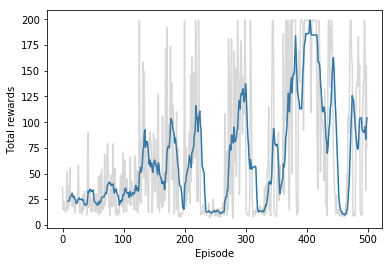

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

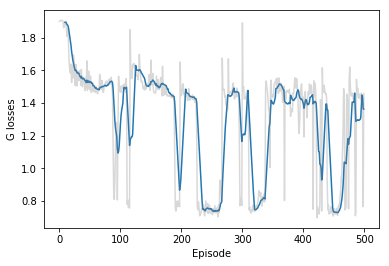

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

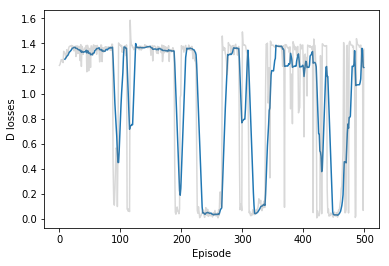

In [26]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.